# $D^0 \to K^0_Sπ^+π^-$ with TFA2

We will fit 

$$
D^0 \to K^0_S \pi^+\pi^-
$$

decays generated with the following intermediate resonances:
- $D^0 \to K^0_S \rho(770)$
- $D^0 \to K^{*-}\pi^+$

Import modules

In [1]:
# Import AmpliTF modules
import amplitf.interface as atfi
import amplitf.kinematics as atfk
import amplitf.dynamics as atfd
import amplitf.likelihood as atfl
from amplitf.phasespace.dalitz_phasespace import DalitzPhaseSpace

# Import TFA modules
import tfa.toymc as tft
import tfa.plotting as tfp
import tfa.optimisation as tfo

2024-10-18 17:03:35.260963: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-18 17:03:35.463695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 17:03:35.591769: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 17:03:35.592803: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 17:03:35.758127: I tensorflow/core/platform/cpu_feature_gua

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Set the number of events to generate and the number of normalisation point to calculate the integral of the likelihood

In [2]:
ntoys = 100000  # Number of points to generate
nnorm = 1000000  # Number of normalisation points

Now define some constants

In [3]:
# Masses of final state particles
from particle.particle import literals as lp
# Dalitz Particles
mkz = atfi.const(lp.K_S_0.mass/1000)
mpi = atfi.const(lp.pi_plus.mass/1000)
md = atfi.const(lp.D_0.mass/1000)

# Resonances
mkst = atfi.const(lp.Kst_892_0.mass/1000)
wkst = atfi.const(lp.Kst_892_0.width/1000)
mrho = atfi.const(lp.rho_770_0.mass/1000)
wrho = atfi.const(lp.rho_770_0.width/1000)

# Blatt-Weisskopf radii for Breit-Wigner lineshape
rd = atfi.const(5.0)
rr = atfi.const(1.5)

2024-10-18 17:03:38.189366: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2024-10-18 17:03:38.189404: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: brownie.mib.infn.it
2024-10-18 17:03:38.189409: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: brownie.mib.infn.it
2024-10-18 17:03:38.189456: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 560.35.3
2024-10-18 17:03:38.189468: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 555.42.6
2024-10-18 17:03:38.189472: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:251] kernel version 555.42.6 does not match DSO version 560.35.3 -- cannot find working devices in this configuration


and a class to deal with three-body Dalitz phase-space

In [4]:
phsp = DalitzPhaseSpace(mpi, mkz, mpi, md)

## Model
Below there is a function to define the model, allowing to switch on and off specific components.

In [5]:
def model(x):

    m2ab = phsp.m2ab(x)
    m2bc = phsp.m2bc(x)
    m2ac = phsp.m2ac(x)

    hel_ab = atfd.helicity_amplitude(phsp.cos_helicity_ab(x), 1)
    hel_bc = atfd.helicity_amplitude(phsp.cos_helicity_bc(x), 1)
    hel_ac = atfd.helicity_amplitude(phsp.cos_helicity_ac(x), 1)

    bw1 = atfd.breit_wigner_lineshape(m2ab, mkst, wkst, mpi, mkz, mpi, md, rd, rr, 1, 1)
    bw2 = atfd.breit_wigner_lineshape(m2bc, mkst, wkst, mpi, mkz, mpi, md, rd, rr, 1, 1)
    bw3 = atfd.breit_wigner_lineshape(m2ac, mrho, wrho, mpi, mpi, mkz, md, rd, rr, 1, 1)

    def _model(a1r, a1i, a2r, a2i, a3r, a3i, switches=4 * [1]):

        a1 = atfi.complex(a1r, a1i)
        a2 = atfi.complex(a2r, a2i)
        a3 = atfi.complex(a3r, a3i)

        ampl = atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
            atfi.const(0.0), atfi.const(0.0)
        )

        if switches[0]:
            ampl += a1 * bw1 * hel_ab
        if switches[1]:
            ampl += a2 * bw2 * hel_bc
        if switches[2]:
            ampl += a3 * bw3 * hel_ac
        if switches[3]:
            ampl += atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
                atfi.const(5.0), atfi.const(0.0)
            )

        return atfd.density(ampl)

    return _model

## Toy MC Model
The model of the toy MC has all the components on by default. By means of the `switches` flag, some of them can be turned off to see the effects on the fit.

In [6]:
def toymc_model(x, switches=4 * [1]):
    return model(x)(
        switches=switches,
        a1r=atfi.const(1.0),
        a1i=atfi.const(0.0),
        a2r=atfi.const(0.5),
        a2i=atfi.const(0.0),
        a3r=atfi.const(2.0),
        a3i=atfi.const(0.0),
    )

## Likelihood

The Negative Log Likelihood

In [7]:
# TF graph for unbinned negalite log likelihood (the quantity to be minimised)
def nll(data, norm):
    data_model = model(data)
    norm_model = model(norm)

    @atfi.function
    def _nll(pars):
        return atfl.unbinned_nll(data_model(**pars), atfl.integral(norm_model(**pars)))

    return _nll

## Samples

The samples to fit

In [8]:
toy_sample = tft.run_toymc(
    toymc_model, phsp, ntoys, maximum=1.0e-20, chunk=1000000, components=False
)

print(toy_sample)

  Updating maximum: 1e-20 -> 964.8408840999736. Starting over.
  Chunk 1, size=27919, total length=27919
  Chunk 2, size=28086, total length=56005
  Chunk 3, size=28115, total length=84120
  Chunk 4, size=28031, total length=112151
tf.Tensor(
[[2.20530105 0.75321537]
 [2.67645438 0.5803689 ]
 [0.8822904  2.66155497]
 ...
 [0.93939868 2.57539454]
 [0.66696337 1.54981667]
 [0.81525047 2.51248932]], shape=(100000, 2), dtype=float64)


and to calculate the integrals

In [9]:
norm_sample = phsp.uniform_sample(nnorm)

print(norm_sample)

tf.Tensor(
[[1.67665507 1.1754912 ]
 [1.7758068  1.25548632]
 [0.76306787 1.98347942]
 ...
 [0.88882302 2.21916174]
 [2.61853269 0.6815718 ]
 [1.19360108 1.68649771]], shape=(474775, 2), dtype=float64)


Beware that only approximately 1/2 of the events have been generated in the normalisation sample.

## Fit

We are now ready to run the fit. We define first the fit parameters:

In [10]:
pars = [
    tfo.FitParameter("a1r", 1.0, -10.0, 10.0),
    tfo.FitParameter("a1i", 0.0, -10.0, 10.0),
    tfo.FitParameter("a2r", 0.5, -10.0, 10.0),
    tfo.FitParameter("a2i", 0.0, -10.0, 10.0),
    tfo.FitParameter("a3r", 2.0, -10.0, 10.0),
    tfo.FitParameter("a3i", 0.0, -10.0, 10.0),
]

and run Minuit

In [11]:
# Run MINUIT minimisation of the neg. log likelihood
result = tfo.run_minuit(nll(toy_sample, norm_sample), pars)
print(result)
cov = result['covariance']

print(f"{result['time']/result['func_calls']} sec per function call")

fitted_pars = {p: atfi.const(v[0]) for p, v in result["params"].items()}

10 -54569.24068081759 [ 1.00000000e+00 -1.61309889e-06  5.00000000e-01  0.00000000e+00
  2.00000000e+00  0.00000000e+00]
20 -54569.24134016551 [1.         0.         0.5        0.         1.99999906 0.        ]
30 -54577.0547557919 [ 9.91166583e-01  9.30016495e-03  4.90504959e-01  8.34679245e-03
  1.97042106e+00 -7.48120436e-04]
40 -54577.1322385024 [ 0.9902309   0.00746165  0.49114268  0.00769351  1.96904652 -0.00221543]
50 -54577.132241530344 [ 0.99023561  0.00746165  0.49114268  0.00769335  1.96904652 -0.00221543]
60 -54577.132241504005 [ 0.99023561  0.00746165  0.49114268  0.00769351  1.96904652 -0.00221704]
70 -54577.13224119866 [ 0.99023561  0.00746165  0.49114268  0.00769351  1.96903726 -0.00221543]
80 -54577.132241492436 [ 0.99023561  0.00746165  0.49114268  0.00769319  1.96904652 -0.00221543]
90 -54577.13223928381 [ 0.99023561  0.00746326  0.49114502  0.00769351  1.96904652 -0.00221543]
┌─────────────────────────────────────────────────────────────────────────┐
│              

Define a function with the fitted model to calculate fit fractions and projections

In [12]:
def fitted_model(x, switches=4 * [1]):
    return model(x)(**fitted_pars, switches=switches)

The fit fractions are calculated

In [13]:
ff = tfo.calculate_fit_fractions(fitted_model, norm_sample)
print(ff)

[0.21622922849843335, 0.053031880950453476, 0.38900791505748544, 0.44222213162393986]


## Plotting

For plotting the results we generate a sample according to the model and we overlay it to the data

In [14]:
fitted_sample = tft.run_toymc(
    fitted_model, phsp, nnorm, maximum=1.0e-20, chunk=1000000, components=True
)

  Updating maximum: 1e-20 -> 952.0916273479268. Starting over.
  Chunk 1, size=28047, total length=28047
  Chunk 2, size=28157, total length=56204
  Chunk 3, size=28300, total length=84504
  Chunk 4, size=28043, total length=112547
  Chunk 5, size=28142, total length=140689
  Chunk 6, size=28279, total length=168968
  Chunk 7, size=28417, total length=197385
  Chunk 8, size=28045, total length=225430
  Chunk 9, size=28110, total length=253540
  Chunk 10, size=27840, total length=281380
  Chunk 11, size=27992, total length=309372
  Chunk 12, size=27830, total length=337202
  Chunk 13, size=28133, total length=365335
  Chunk 14, size=27920, total length=393255
  Chunk 15, size=28148, total length=421403
  Chunk 16, size=28100, total length=449503
  Chunk 17, size=27640, total length=477143
  Chunk 18, size=28030, total length=505173
  Chunk 19, size=28014, total length=533187
  Chunk 20, size=28105, total length=561292
  Chunk 21, size=27897, total length=589189
  Chunk 22, size=27914, t

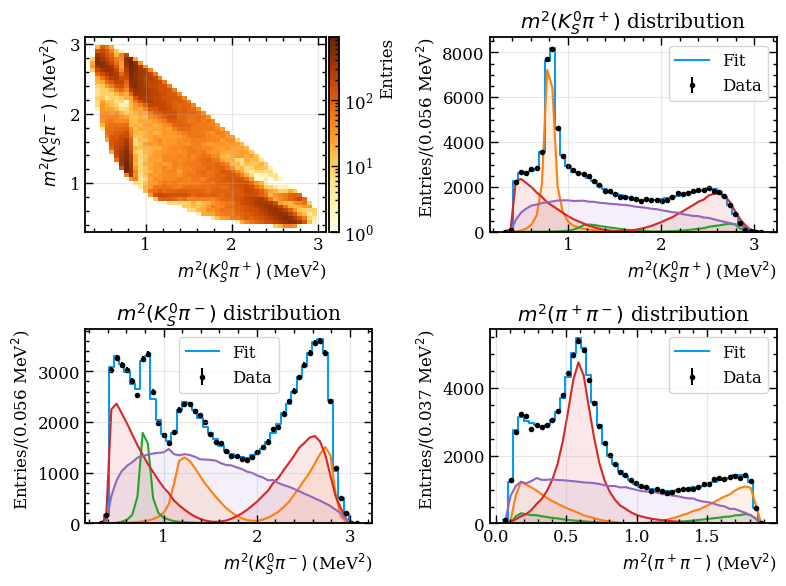

In [15]:
# Plot results
import matplotlib.pyplot as plt

tfp.set_lhcb_style(size=12, usetex=False)  # Adjust plotting style for LHCb papers
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))  # Single subplot on the figure

# Plot 1D histogram from the toy MC sample
tfp.plot_distr2d(
    toy_sample[:, 0],
    toy_sample[:, 1],
    bins=(50, 50),
    ranges=((0.3, 3.1), (0.3, 3.1)),
    fig=fig,
    ax=ax[0, 0],
    labels=(r"$m^2(K_S^0\pi^+)$", r"$m^2(K_S^0\pi^-)$"),
    units=("MeV$^2$", "MeV$^2$"),
    log=True,
)

tfp.plot_distr1d_comparison(
    toy_sample[:, 0],
    fitted_sample[:, 0],
    cweights=[fitted_sample[:, 2 + i] for i in range(4)],
    bins=50,
    range=(0.3, 3.1),
    ax=ax[0, 1],
    label=r"$m^2(K_S^0\pi^+)$",
    units="MeV$^2$",
)

tfp.plot_distr1d_comparison(
    toy_sample[:, 1],
    fitted_sample[:, 1],
    cweights=[fitted_sample[:, 2 + i] for i in range(4)],
    bins=50,
    range=(0.3, 3.1),
    ax=ax[1, 0],
    label=r"$m^2(K_S^0\pi^-)$",
    units="MeV$^2$",
)

tfp.plot_distr1d_comparison(
    phsp.m2ac(toy_sample),
    phsp.m2ac(fitted_sample),
    cweights=[fitted_sample[:, 2 + i] for i in range(4)],
    bins=50,
    range=(0.05, 1.9),
    ax=ax[1, 1],
    label=r"$m^2(\pi^+\pi^-)$",
    units="MeV$^2$",
)

# Show the plot
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

In [16]:
samp = phsp.filter(phsp.unfiltered_sample(1000))

In [17]:
model(samp)

<function __main__.model.<locals>._model(a1r, a1i, a2r, a2i, a3r, a3i, switches=[1, 1, 1, 1])>